In [1]:
# Import statements
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import joblib
from sklearn.preprocessing import StandardScaler
import random
import os
import sys
project_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_path)

# Data Pre Processing

In [4]:
from utils.air_quality_pre_processor import AirQualityProcessor
# Load Beijing Multisite Air Quality Data
Aoti_data = pd.read_csv('../data/air_quality_cluster/PRSA_Data_Aotizhongxin_20130301-20170228.csv');
# Example data
processed_aoti_data = AirQualityProcessor(Aoti_data)
forecast_columns = processed_aoti_data.preprocess_airquality_data()


## Simulate industrial Data

TODOs:

1. Predict PM2.5 using other exogenous features

2. Downsample PM2.5

3. Break in 4 tasks

4. Translate

### Original Data Visualization

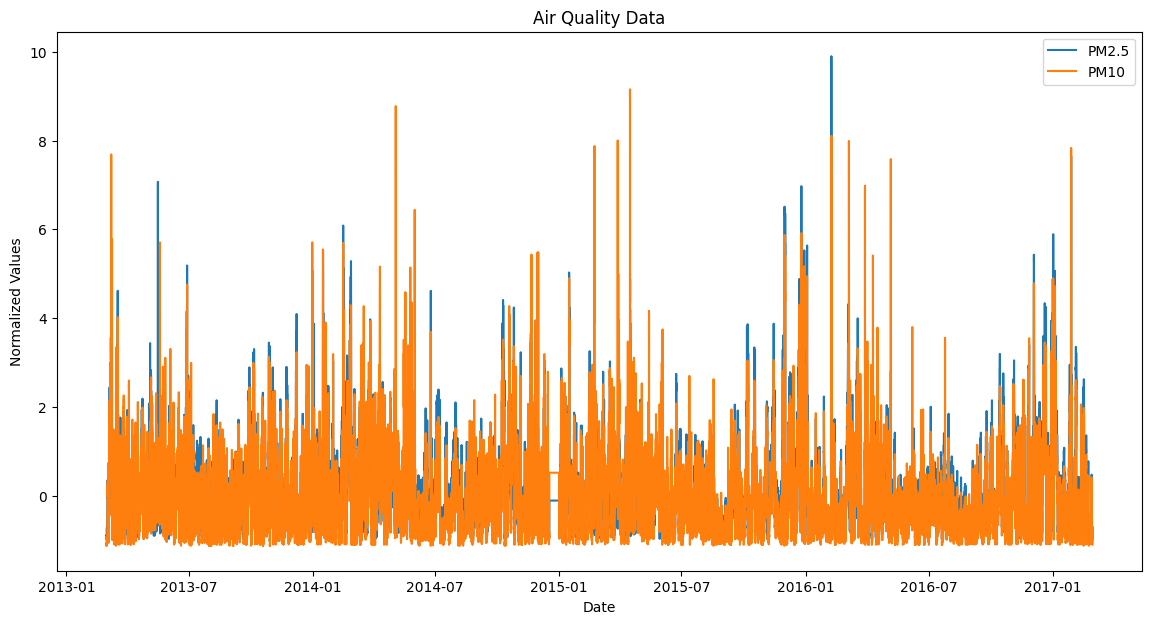

In [44]:
# Plot the data date vs PM2.5, PM10, SO2, NO2, CO, O3
plt.figure(figsize=(14, 7))
plt.plot(Aoti_data['date'], Aoti_data['PM2.5'], label='PM2.5')
plt.plot(Aoti_data['date'], Aoti_data['PM10'], label='PM10')
plt.xlabel('Date')
plt.ylabel('Normalized Values')
plt.title('Air Quality Data')
plt.legend()
plt.show()

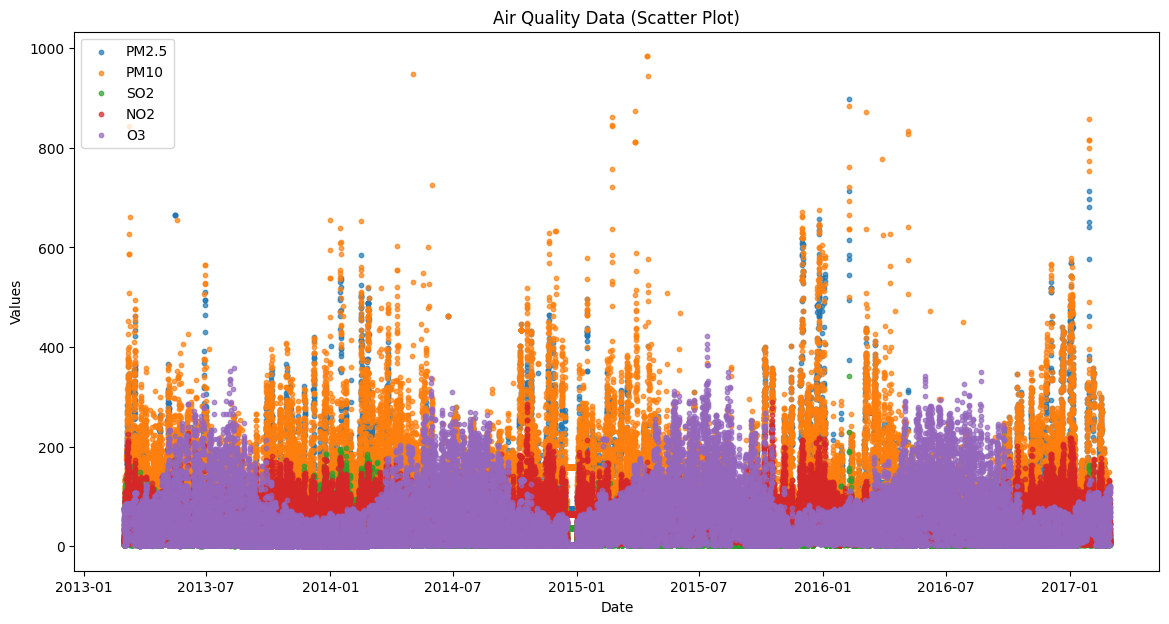

In [32]:
# Scatter plot for date vs PM2.5 and PM10 and SO2, NO2, CO, O3
plt.figure(figsize=(14, 7))
plt.scatter(Aoti_data['date'], Aoti_data['PM2.5'], label='PM2.5', alpha=0.7, s=10)
plt.scatter(Aoti_data['date'], Aoti_data['PM10'], label='PM10', alpha=0.7, s=10)
plt.scatter(Aoti_data['date'], Aoti_data['SO2'], label='SO2', alpha=0.7, s=10)
plt.scatter(Aoti_data['date'], Aoti_data['NO2'], label='NO2', alpha=0.7, s=10)
# plt.scatter(Aoti_data['date'], Aoti_data['CO'], label='CO', alpha=0.7, s=10)
plt.scatter(Aoti_data['date'], Aoti_data['O3'], label='O3', alpha=0.7, s=10)

plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Air Quality Data (Scatter Plot)')
plt.legend()
plt.show()

In [45]:
# Print Date Range
print('Date Range: ', Aoti_data['date'].min(), ' to ', Aoti_data['date'].max())

Date Range:  2013-03-01 00:00:00  to  2017-02-28 23:00:00


In [46]:
# Get data for row 2013-03-01 00:00:00
print(Aoti_data[Aoti_data['date'] == '2013-03-01 00:00:00'])

        date     PM2.5      PM10       SO2       NO2        CO        O3  \
0 2013-03-01 -0.962014 -1.119098 -0.594822 -1.412992 -0.778576  0.378863   

       TEMP     PRES     DEWP      RAIN      WSPM  
0 -1.252733  1.07146 -1.60114 -0.074064  2.235205  


In [47]:
# get Frequency of data
print('Frequency of data: ', Aoti_data['date'].diff().value_counts())

Frequency of data:  0 days 01:00:00    35063
Name: date, dtype: int64


### Resample PM2.5 to a lower frequency.

In [79]:
Aoti_data.head()

,date,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM
0,2013-03-01 00:00:00,-0.962014,-1.119098,-0.594822,-1.412992,-0.778576,0.378863,-1.252733,1.071460,-1.601140,-0.074064,2.235205
1,2013-03-01 01:00:00,-0.913405,-1.077158,-0.594822,-1.412992,-0.778576,0.378863,-1.287819,1.090682,-1.557314,-0.074064,2.484342
2,2013-03-01 02:00:00,-0.925557,-1.087643,-0.550998,-1.331926,-0.778576,0.309396,-1.287819,1.119515,-1.557314,-0.074064,3.231755
3,2013-03-01 03:00:00,-0.937709,-1.098128,-0.288059,-1.304905,-0.778576,0.292030,-1.314133,1.215625,-1.644967,-0.074064,1.155608
4,2013-03-01 04:00:00,-0.974166,-1.129583,-0.244236,-1.277883,-0.778576,0.292030,-1.366762,1.282902,-1.652271,-0.074064,0.242103


In [91]:
# Downsample the PM2.5 column to a 3-day frequency.
Aoti_data.set_index('date', inplace=True)
Aoti_data_resampled_pm25 = Aoti_data['PM2.5'].resample('3D').mean()
Aoti_data['PM2.5_3D'] = Aoti_data_resampled_pm25.reindex(Aoti_data.index)
Aoti_data.reset_index(inplace=True)


### Breaking Data in Multiple Tasks

In [93]:
# Split The Dataset into 4 parts, 2013-03-01 to 2014-02-28, 2014-03-01 to 2015-02-28, 2015-03-01 to 2016-02-29, 2016-03-01 to 2017-02-28
data_2013 = Aoti_data[(Aoti_data['date'] >= '2013-03-01') & (Aoti_data['date'] <= '2014-02-28')]
data_2014 = Aoti_data[(Aoti_data['date'] >= '2014-03-01') & (Aoti_data['date'] <= '2015-02-28')]
data_2015 = Aoti_data[(Aoti_data['date'] >= '2015-03-01') & (Aoti_data['date'] <= '2016-02-29')]
data_2016 = Aoti_data[(Aoti_data['date'] >= '2016-03-01') & (Aoti_data['date'] <= '2017-02-28')]

Assign Unique id to each partition

In [94]:
# Assign a unique cluster_id to each dataset
data_2013['cluster_id'] = 1
data_2014['cluster_id'] = 2
data_2015['cluster_id'] = 3
data_2016['cluster_id'] = 4

/var/folders/n2/ynmqlkx14wd993676tgwybz80000gn/T/ipykernel_37005/611746620.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2013['cluster_id'] = 1
/var/folders/n2/ynmqlkx14wd993676tgwybz80000gn/T/ipykernel_37005/611746620.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2014['cluster_id'] = 2
/var/folders/n2/ynmqlkx14wd993676tgwybz80000gn/T/ipykernel_37005/611746620.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

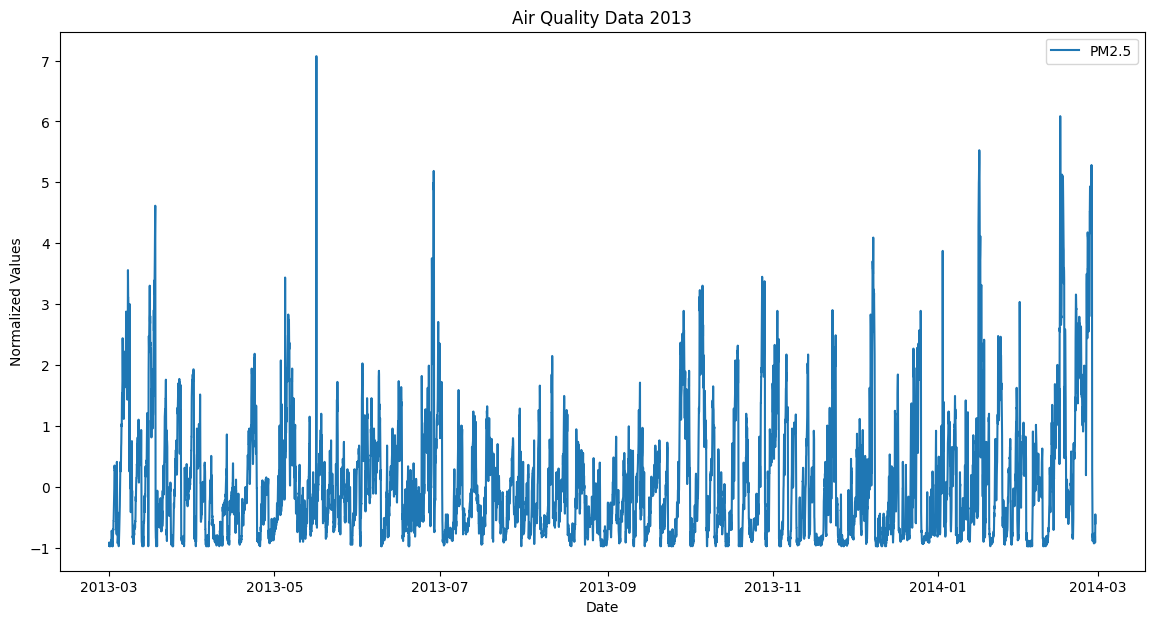

In [96]:
# Plot the data date vs PM2.5, PM10, SO2, NO2, CO, O3, TEMP, PRES, DEWP, RAIN, WSPM, for 2013, 2014, 2015, 2016
plt.figure(figsize=(14, 7))
plt.plot(data_2013['date'], data_2013['PM2.5'], label='PM2.5')
plt.plot(data_2013['date'], data_2013['PM10'], label='PM10')
plt.plot(data_2013['date'], data_2013['SO2'], label='SO2')
plt.xlabel('Date')
plt.ylabel('Normalized Values')
plt.title('Air Quality Data 2013')
plt.legend()

### Random Translation to Simulate Repairs

In [97]:
# Generate random translation values
random_up_2014 = np.random.uniform(10, 20)  # Translate up by 10-20 units
random_down_2015 = np.random.uniform(-20, -10)  # Translate down by 10-20 units
random_up_2016 = np.random.uniform(5, 15)  # Translate up by 5-15 units

# apply translation to all columns of 2014, 2015, 2016 data
data_2014[forecast_columns] += random_up_2014
data_2015[forecast_columns] += random_down_2015
data_2016[forecast_columns] += random_up_2016

/var/folders/n2/ynmqlkx14wd993676tgwybz80000gn/T/ipykernel_37005/2939188892.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2014[forecast_columns] += random_up_2014
/var/folders/n2/ynmqlkx14wd993676tgwybz80000gn/T/ipykernel_37005/2939188892.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2015[forecast_columns] += random_down_2015
/var/folders/n2/ynmqlkx14wd993676tgwybz80000gn/T/ipykernel_37005/2939188892.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

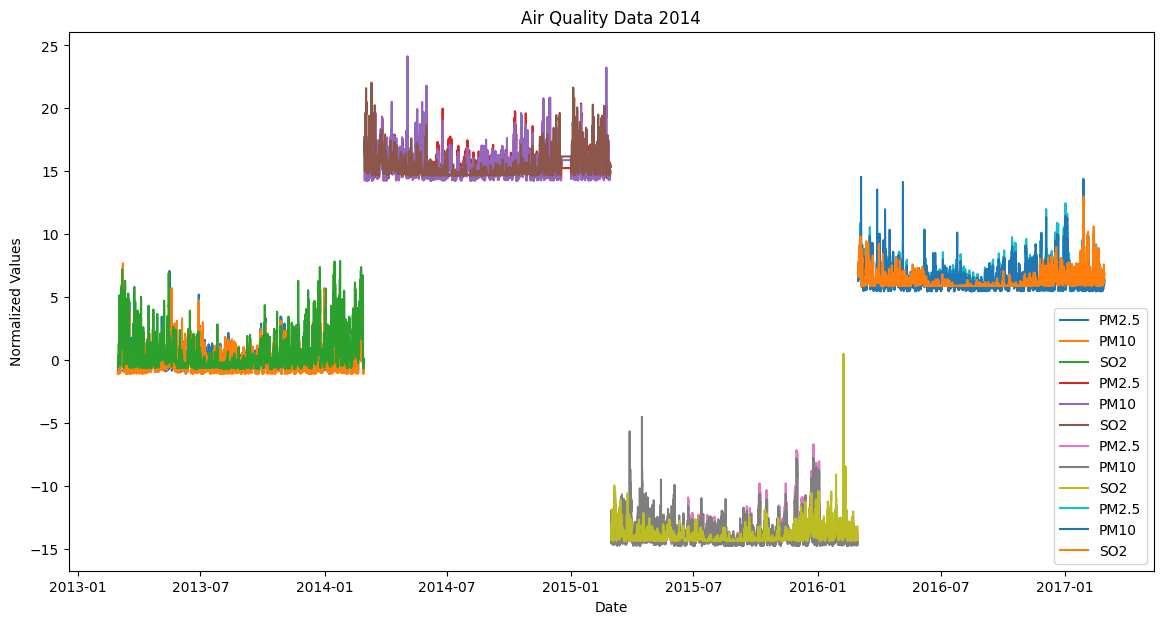

In [101]:
# Plot the data date vs PM2.5, PM10, SO2, NO2, CO, O3, TEMP, PRES, DEWP, RAIN, WSPM, for 2013, 2014, 2015, 2016
plt.figure(figsize=(14, 7))
plt.plot(data_2013['date'], data_2013['PM2.5'], label='PM2.5')
plt.plot(data_2013['date'], data_2013['PM10'], label='PM10')
plt.plot(data_2013['date'], data_2013['SO2'], label='SO2')
plt.plot(data_2014['date'], data_2014['PM2.5'], label='PM2.5')
plt.plot(data_2014['date'], data_2014['PM10'], label='PM10')
plt.plot(data_2014['date'], data_2014['SO2'], label='SO2')
plt.plot(data_2015['date'], data_2015['PM2.5'], label='PM2.5')
plt.plot(data_2015['date'], data_2015['PM10'], label='PM10')
plt.plot(data_2015['date'], data_2015['SO2'], label='SO2')
plt.plot(data_2016['date'], data_2016['PM2.5'], label='PM2.5')
plt.plot(data_2016['date'], data_2016['PM10'], label='PM10')
plt.plot(data_2016['date'], data_2016['SO2'], label='SO2')

plt.xlabel('Date')
plt.ylabel('Normalized Values')
plt.title('Air Quality Data 2014')
plt.legend()

In [73]:
# concatenate the data for 2013, 2014, 2015, 2016
data_translated = pd.concat([data_2013, data_2014, data_2015, data_2016], axis=0)

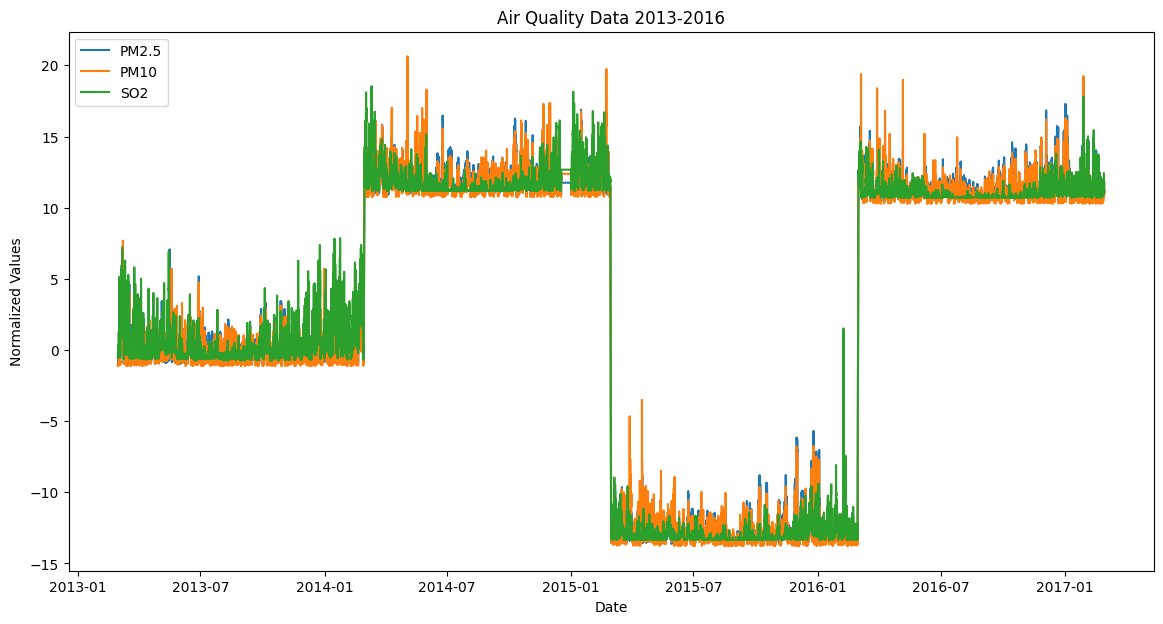

In [74]:
# Plot
plt.figure(figsize=(14, 7))
plt.plot(data_translated['date'], data_translated['PM2.5'], label='PM2.5')
plt.plot(data_translated['date'], data_translated['PM10'], label='PM10')
plt.plot(data_translated['date'], data_translated['SO2'], label='SO2')
plt.xlabel('Date')
plt.ylabel('Normalized Values')
plt.title('Air Quality Data 2013-2016')
plt.legend()

In [ ]:
from utils.generate_simulation_data import generate_simulated_time_series

simulated_data = generate_simulated_time_series(processed_aoti_data.data ,date_column="date", columns=forecast_columns ,n_tasks=4, resample_frequency='3D')

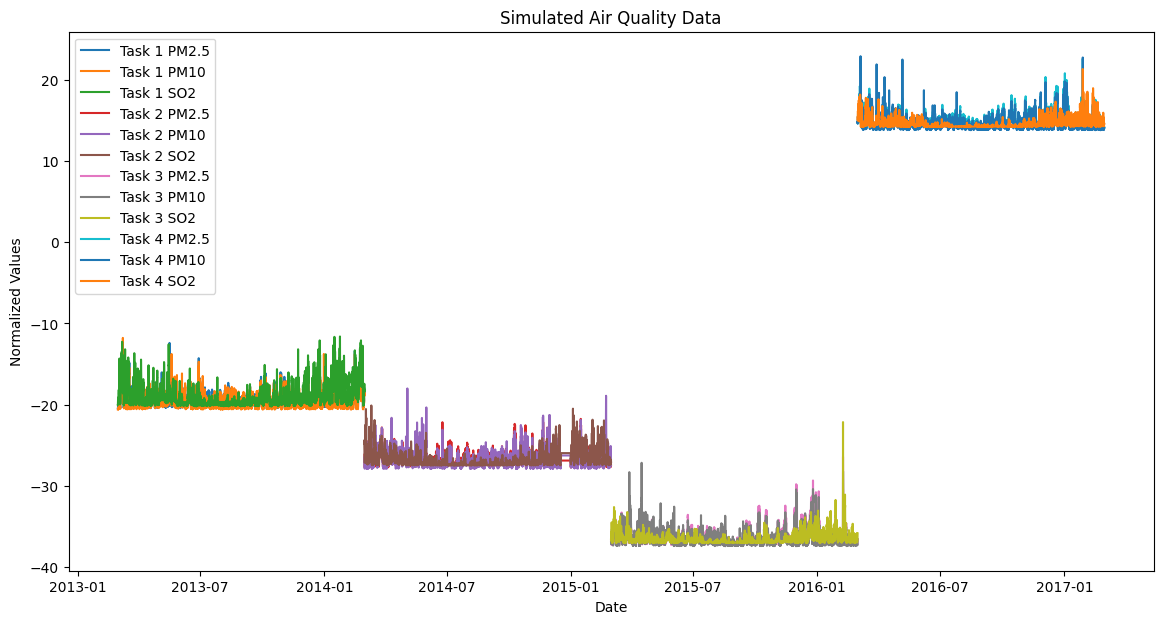

In [171]:
# Plot the data for each task PM2.5, PM10, SO2, NO2
plt.figure(figsize=(14, 7))
# Plot the data for each task PM2.5, PM10, SO2, NO2
for i, task_data in enumerate(simulated_data):
    plt.plot(task_data['date'], task_data['PM2.5'], label=f'Task {i + 1} PM2.5')
    plt.plot(task_data['date'], task_data['PM10'], label=f'Task {i + 1} PM10')
    plt.plot(task_data['date'], task_data['SO2'], label=f'Task {i + 1} SO2')    
    plt.xlabel('Date')
    plt.ylabel('Normalized Values')
    plt.title('Simulated Air Quality Data')
    plt.legend()



## Test Simulation Data Generation on Other Datasets

In [3]:
# Load Rossman Sales Data
from utils.rossman_store_pre_processor import RossmanDataProcessor


rossman_data = pd.read_csv('../data/rossman/train.csv')
# Initialize the Rossman Data Processor
processor = RossmanDataProcessor(rossman_data)
# Preprocess the data
forecast_columns = processor.preprocess_rossman_data()
# Print the forecast columns
print('Forecast Columns:', forecast_columns)


/var/folders/n2/ynmqlkx14wd993676tgwybz80000gn/T/ipykernel_15108/2833347330.py:5: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  rossman_data = pd.read_csv('../data/rossman/train.csv')


Forecast Columns: ['Store', 'DayOfWeek', 'Promo', 'Holiday', 'Sales', 'Customers']


In [4]:
processor.data.head()

,Date,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Holiday
0,2015-07-31,1,5,-0.132683,-0.168269,1,1.273237,0,1,1
1,2015-07-31,2,5,0.075373,-0.017540,1,1.273237,0,1,1
2,2015-07-31,3,5,0.659800,0.404499,1,1.273237,0,1,1
3,2015-07-31,4,5,2.135414,1.862258,1,1.273237,0,1,1
4,2015-07-31,5,5,-0.247231,-0.159656,1,1.273237,0,1,1


In [5]:
from utils.generate_simulation_data import generate_simulated_time_series
# generate simulated data
simulated_data = generate_simulated_time_series(processor.data ,date_column="Date", forecast_columns=forecast_columns ,n_tasks=4, resample_frequency='3D')

/Users/arnobchowdhury/anaconda3/envs/Multiple-time-series/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/arnobchowdhury/anaconda3/envs/Multiple-time-series/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


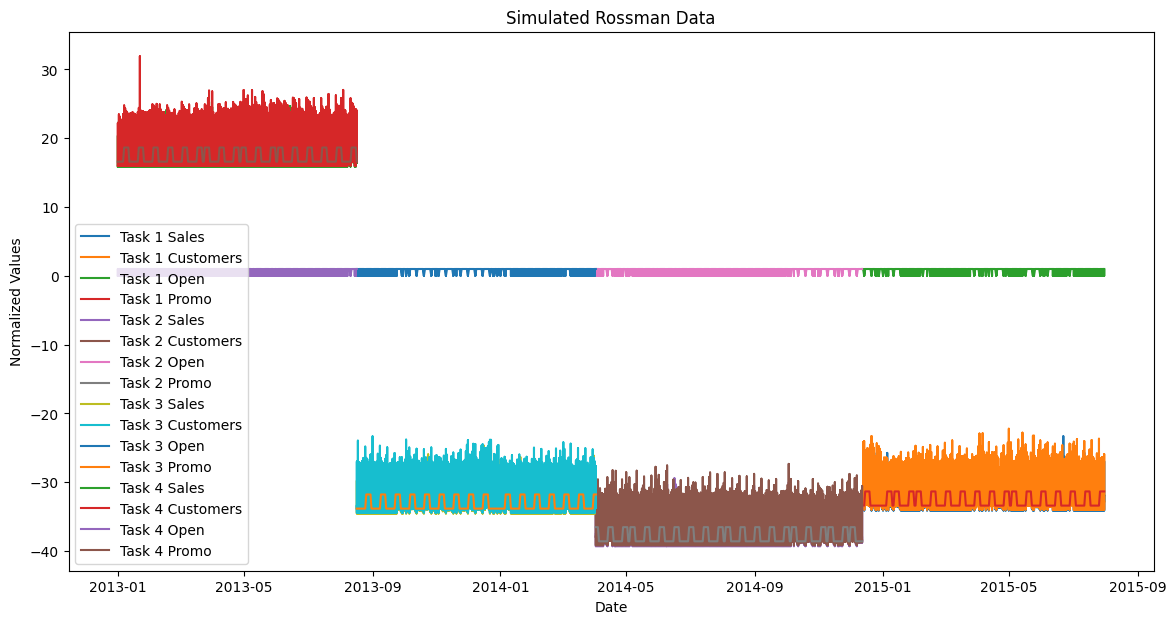

In [8]:
# Plot the data for each task Sales, Customers, Open, Promo 
plt.figure(figsize=(14, 7))
# Plot the data for each task Sales, Customers, Open, Promo
for i, task_data in enumerate(simulated_data):
    plt.plot(task_data['Date'], task_data['Sales'], label=f'Task {i + 1} Sales')
    plt.plot(task_data['Date'], task_data['Customers'], label=f'Task {i + 1} Customers')
    plt.plot(task_data['Date'], task_data['Open'], label=f'Task {i + 1} Open')
    plt.plot(task_data['Date'], task_data['Promo'], label=f'Task {i + 1} Promo')
    plt.xlabel('Date')
    plt.ylabel('Normalized Values')
    plt.title('Simulated Rossman Data')
    plt.legend()

In [21]:
from data_provider.data_loader import Dataset_ETT_hour


data = Dataset_ETT_hour(root_path='./',
                        data_path='../data/ETTh1.csv', 
                        flag='train',
                        features='M')

/Users/arnobchowdhury/Documents/university_work/Thesis/centralized-baseline/data_provider/data_loader.py:70: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data_stamp = df_stamp.drop(['date'], 1).values


In [22]:
# print head of the data
data.data_y.shape

(8640, 7)

In [7]:
from torch.utils.data import DataLoader

In [8]:
data_loader = DataLoader(
        data,
        batch_size=16,
        shuffle=True,
        num_workers=1,
        drop_last=True)

In [23]:
# I need data and data_loader.